In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt



In [12]:

df = pd.read_csv('data/powerball_only_cleaned_231007.csv')

# Now 'df' contains your data in a DataFrame


In [13]:
df.head()

,s
0,19
1,1
2,5
3,22
4,7


In [14]:


# #rename columns
df = df.rename(columns={"s":"numbers"})

# #convert date to dt, refomat to yyyymmdd
# df['Date'] = pd.to_datetime(df['Date']).dt.date

# #json return began with most recent date, reversed for plotting/analysis
# df = df.reindex(index=df.index[::-1])

# #set date as index
# df.set_index('Date', inplace=True)
numbers_df= df.copy()

numbers_df.head()

,numbers
0,19
1,1
2,5
3,22
4,7


In [15]:
# stacked_list = df.stack().tolist()

# stacked_list[0:5]

In [16]:
# numbers_df = pd.DataFrame(stacked_list, columns=["numbers"])

# numbers_df.head()

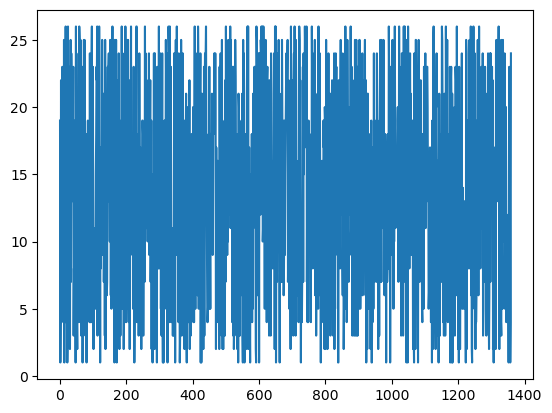

In [17]:
#plot historical amzn price
plt.plot(numbers_df)

In [18]:
# Set parameters for model

lookback = 30

split_1 = .8
split_2 = .9

In [19]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'numbers(t-{i})'] = data['numbers'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(numbers_df, lookback)

shifted_df.head()

,numbers,numbers(t-1),numbers(t-2),numbers(t-3),numbers(t-4),numbers(t-5),numbers(t-6),numbers(t-7),numbers(t-8),numbers(t-9),...,numbers(t-21),numbers(t-22),numbers(t-23),numbers(t-24),numbers(t-25),numbers(t-26),numbers(t-27),numbers(t-28),numbers(t-29),numbers(t-30)
30,2,13.0,5.0,23.0,22.0,3.0,26.0,3.0,1.0,13.0,...,5.0,9.0,23.0,21.0,4.0,7.0,22.0,5.0,1.0,19.0
31,14,2.0,13.0,5.0,23.0,22.0,3.0,26.0,3.0,1.0,...,18.0,5.0,9.0,23.0,21.0,4.0,7.0,22.0,5.0,1.0
32,25,14.0,2.0,13.0,5.0,23.0,22.0,3.0,26.0,3.0,...,5.0,18.0,5.0,9.0,23.0,21.0,4.0,7.0,22.0,5.0
33,7,25.0,14.0,2.0,13.0,5.0,23.0,22.0,3.0,26.0,...,25.0,5.0,18.0,5.0,9.0,23.0,21.0,4.0,7.0,22.0
34,24,7.0,25.0,14.0,2.0,13.0,5.0,23.0,22.0,3.0,...,1.0,25.0,5.0,18.0,5.0,9.0,23.0,21.0,4.0,7.0


In [20]:
shifted_df = shifted_df.astype(int)

shifted_df.head()

,numbers,numbers(t-1),numbers(t-2),numbers(t-3),numbers(t-4),numbers(t-5),numbers(t-6),numbers(t-7),numbers(t-8),numbers(t-9),...,numbers(t-21),numbers(t-22),numbers(t-23),numbers(t-24),numbers(t-25),numbers(t-26),numbers(t-27),numbers(t-28),numbers(t-29),numbers(t-30)
30,2,13,5,23,22,3,26,3,1,13,...,5,9,23,21,4,7,22,5,1,19
31,14,2,13,5,23,22,3,26,3,1,...,18,5,9,23,21,4,7,22,5,1
32,25,14,2,13,5,23,22,3,26,3,...,5,18,5,9,23,21,4,7,22,5
33,7,25,14,2,13,5,23,22,3,26,...,25,5,18,5,9,23,21,4,7,22
34,24,7,25,14,2,13,5,23,22,3,...,1,25,5,18,5,9,23,21,4,7


In [21]:
from sklearn.preprocessing import StandardScaler

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

#Scale data
# log_transformed_data = np.log(shifted_df_as_np)
# scaler = StandardScaler()

# scaled_data = scaler.fit_transform(shifted_df_as_np)


# split reference from deatures
X1 = shifted_df_as_np[:, 1:]
y1 = shifted_df_as_np[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((1330, 30), (1330,), (1330,))

In [22]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1064, 30), (1064,), (133, 30), (133,), (133, 30), (133,))

In [23]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.01),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-10-08 23:14:06.941366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
34/34 [==============================] - 4s 40ms/step - loss: 76.2749 - mean_absolute_error: 7.3366 - val_loss: 58.4087 - val_mean_absolute_error: 6.5487
Epoch 2/100
34/34 [==============================] - 1s 21ms/step - loss: 58.8366 - mean_absolute_error: 6.6100 - val_loss: 63.1280 - val_mean_absolute_error: 6.7118
Epoch 3/100
34/34 [==============================] - 1s 21ms/step - loss: 58.3302 - mean_absolute_error: 6.6178 - val_loss: 57.9450 - val_mean_absolute_error: 6.5350
Epoch 4/100
34/34 [==============================] - 1s 17ms/step - loss: 59.7334 - mean_absolute_error: 6.6949 - val_loss: 57.2240 - val_mean_absolute_error: 6.5169
Epoch 5/100
34/34 [==============================] - 1s 22ms/step - loss: 57.4368 - mean_absolute_error: 6.5799 - val_loss: 57.0602 - val_mean_absolute_error: 6.5119
Epoch 6/100
34/34 [==============================] - 1s 23ms/step - loss: 57.9398 - mean_absolute_error: 6.5796 - val_loss: 56.4889 - val_mean_absolute_error: 6.4986
Epoc

34/34 [==============================] - 1s 22ms/step - loss: 61.6200 - mean_absolute_error: 6.6700 - val_loss: 58.6966 - val_mean_absolute_error: 6.6345
Epoch 51/100
34/34 [==============================] - 1s 19ms/step - loss: 57.8198 - mean_absolute_error: 6.5709 - val_loss: 60.7678 - val_mean_absolute_error: 6.6163
Epoch 52/100
34/34 [==============================] - 1s 21ms/step - loss: 56.9931 - mean_absolute_error: 6.5540 - val_loss: 59.7722 - val_mean_absolute_error: 6.5818
Epoch 53/100
34/34 [==============================] - 1s 19ms/step - loss: 56.8953 - mean_absolute_error: 6.5400 - val_loss: 56.4007 - val_mean_absolute_error: 6.4776
Epoch 54/100
34/34 [==============================] - 1s 17ms/step - loss: 57.7215 - mean_absolute_error: 6.5470 - val_loss: 56.6302 - val_mean_absolute_error: 6.4793
Epoch 55/100
34/34 [==============================] - 1s 16ms/step - loss: 57.9599 - mean_absolute_error: 6.5692 - val_loss: 57.4572 - val_mean_absolute_error: 6.4958
Epoch 56/10

34/34 [==============================] - 1s 19ms/step - loss: 58.0608 - mean_absolute_error: 6.5293 - val_loss: 57.9817 - val_mean_absolute_error: 6.4966
Epoch 100/100
34/34 [==============================] - 1s 19ms/step - loss: 56.3862 - mean_absolute_error: 6.4650 - val_loss: 57.7800 - val_mean_absolute_error: 6.5144


34/34 [==============================] - 1s 5ms/step


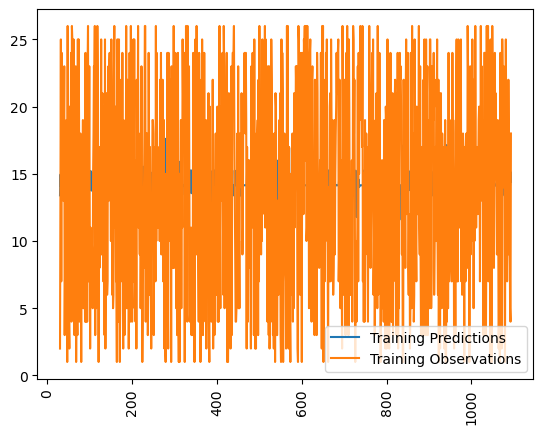

In [24]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, (train_predictions))
plt.plot(dates_train1, (y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [25]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 57.779972076416016
Val MAE: 6.514374732971191


5/5 [==============================] - 0s 6ms/step


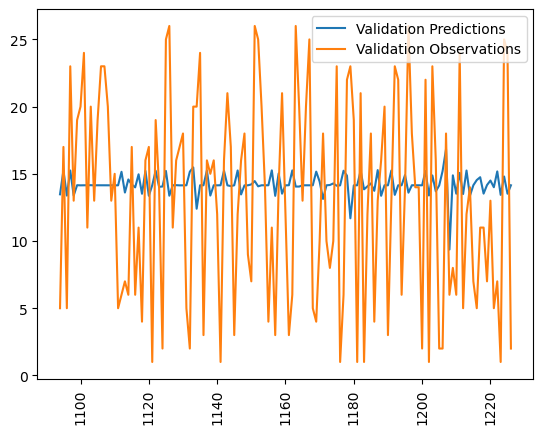

In [26]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, (val_predictions))
plt.plot(dates_val1, (y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [27]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 61.443111419677734
Test MAE: 6.794097423553467


5/5 [==============================] - 0s 12ms/step


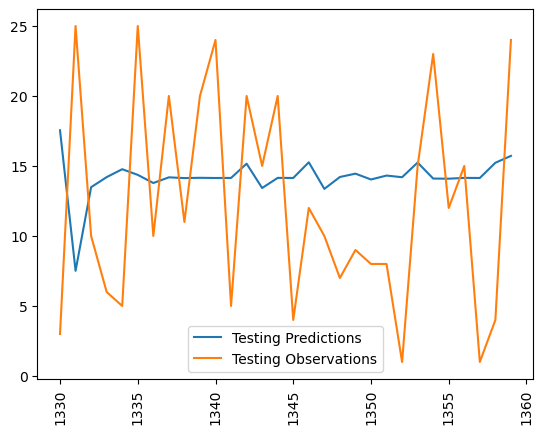

In [28]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1[-30:],(test_predictions[-30:]))
plt.plot(dates_test1[-30:], (y_test1[-30:]))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [29]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  -0.09196008052296856


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends

In [30]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 10

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test1[-1]
current_reshape = current_batch.reshape((1, lookback, 1))
# initial_date = dates_test1[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback, 1))

    
# for day in date_range:
#     new_date = initial_date + dt.timedelta(days=day)
#     predicted_dates.append(new_date
#                           )
# 'predictions' contains 7-day forecast
print(predictions)

# for date in predicted_dates:
#     print(date)

1/1 [==============================] - 0s 36ms/step
[15.720731, 13.363487, 15.265189, 15.260515, 15.260501, 15.260501, 15.260499, 15.260499, 15.260499, 15.260499]


In [31]:
# Export model1 to HDF5 file
model.save("pb.h5")

In [32]:
int_predictions = [round(x) for x in predictions]

int_predictions

[16, 13, 15, 15, 15, 15, 15, 15, 15, 15]

In [36]:
winner = int_predictions[0:1]

In [37]:

print(winner)

[16]
